<a href="https://colab.research.google.com/github/CristianMorasso/statistical_project/blob/master/Copia_di_statiscal_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical Learning Project: ALFA Dataset Anaysis


## Setup:

### Download the dataset and parse the files

In [1]:
# If KNeighborsTimeSeriesClassifier hasnt been fixed yet install from source the branch with the fixed version:
! git clone  https://github.com/Z-Fran/sktime.git
! cd sktime && git checkout kneibor-duplication && git pull
! cd sktime && pip install .

# For dist folder
! cd sktime && pip install build && python -m build --wheel

Streaming output truncated to the last 5000 lines.
copying build/lib/sktime/performance_metrics/tests/_config.py -> build/bdist.linux-x86_64/wheel/sktime/performance_metrics/tests
copying build/lib/sktime/performance_metrics/tests/test_performance_metrics_forecasting.py -> build/bdist.linux-x86_64/wheel/sktime/performance_metrics/tests
copying build/lib/sktime/performance_metrics/tests/test_numpy_metrics.py -> build/bdist.linux-x86_64/wheel/sktime/performance_metrics/tests
copying build/lib/sktime/performance_metrics/tests/__init__.py -> build/bdist.linux-x86_64/wheel/sktime/performance_metrics/tests
copying build/lib/sktime/performance_metrics/tests/test_metrics_classes.py -> build/bdist.linux-x86_64/wheel/sktime/performance_metrics/tests
creating build/bdist.linux-x86_64/wheel/sktime/performance_metrics/base
copying build/lib/sktime/performance_metrics/base/_base.py -> build/bdist.linux-x86_64/wheel/sktime/performance_metrics/base
copying build/lib/sktime/performance_metrics/base/__i

In [2]:
# Download the dataset from our git repository hosted on Github
!pip install icecream scikit-learn polars numpy imbalanced-learn # sktime
!rm -rf statiscal_project
!git clone https://github.com/CristianMorasso/statistical_project.git

LEN_DATASET = 45

Cloning into 'statistical_project'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 124 (delta 22), reused 3 (delta 1), pack-reused 70
Receiving objects: 100% (124/124), 91.05 MiB | 9.27 MiB/s, done.
Resolving deltas: 100% (22/22), done.
Updating files: 100% (65/65), done.


In [3]:
# Read the data from the csv files
import numpy as np
import pandas  as pd
import os
from random import shuffle

dataset_dir = "statistical_project/data"
dfs = [] # dataframe list

classToString= {0:"no_failure", 1:"elevator", 2:"engine", 3:"rudder",4:"ailerons"}

stringToClass = {}
for key, value in classToString.items():
  stringToClass[value] = key

series_counter = 0

for _, cl  in enumerate(os.listdir(dataset_dir)):
  path1 = os.path.join(dataset_dir, cl)

  # Get rid of files or bad dirs
  if not os.path.isdir(path1) or cl == "features":
    print(f"{cl} is not a dir or not useful!")
    continue

  for f in  os.listdir(path1):
    pathf = os.path.join(path1, f)
    df = pd.read_csv(pathf)

    # Fix the label field
    try:
      df["field.data"] = df["field.data"].apply(func=lambda x: stringToClass[cl] if int(x)>0 else 0)
      df = df.rename(columns={"field.data": "Y"})
    except:
      print(f"Error for {cl}")
      df["Y"]  = pd.Series([ 0 for _ in range(df.shape[0])])

    # Drop the time column!
    df = df.drop("%time", axis=1)

    # Save it
    dfs.append(df)
    series_counter+=1

print(f"\nNumber of Time Series: {len(dfs)}")
assert len(dfs) == LEN_DATASET # We know the exact number from the repo

# Shuffle the array of dataframes for so that classes are not contiguous
shuffle(dfs)

Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
__init__.py is not a dir or not useful!
features is not a dir or not useful!
README.md is not a dir or not useful!

Number of Time Series: 45


### Remove unusable features and Inpute missing values

In [4]:
from sklearn.impute import SimpleImputer
import numpy as np

# Remove useless features and inpute missing values
#
# finally use the mask on every timeseries of the OG dataframes list

# Remove all the features that are not shared by all Time Series
#
# Only use the variables that can be found in all the dataframes
features = []
# Get the biggest set:
# (We are considering that that the bigger set is just a superset and has all the other base features)
for df in dfs:
   features = max(features, df.columns.values, key=lambda x: len(x))
# Then get the set intersection of all of the features sets
features = set(features)
for df in dfs:
  features = features.intersection(set(df.columns.values))

# Apply the feature mask
print(len(features))
dfs = list(map(lambda x: x[list(features)] , dfs))

# Concat all the time series in as single dataframe for later :)
concatted_dfs = pd.concat(dfs)
concatted_y = concatted_dfs["Y"]
concatted_dfs = concatted_dfs.drop("Y", axis=1)

26


In [5]:
from sklearn.impute import SimpleImputer
import numpy as np

# Inpute the missing values first
dfs = list(map(lambda x: SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(x) , dfs))

### Split the dataset into windows

In [6]:
from sktime.split import SlidingWindowSplitter

splitted_ndarrays, window_length, step_length = [], 10, 10
splitter = SlidingWindowSplitter(window_length=window_length, step_length=step_length)
splitted_ndarrays = [ list(map(lambda x: x[0], splitter.split_series(df))) for df in dfs] # We are ignoring the forecasting horizon

print(f"Length of windowed dataset: {len(splitted_ndarrays)}")
assert len(splitted_ndarrays) == LEN_DATASET

Length of windowed dataset: 45


In [7]:
# Split into windows
_splitted_ndarrays = []
_splitted_ys = []
features = list(features)
y_index = features.index("Y") # Index of the Y column
features.pop(y_index)
#features = ["flight", "step", *features]

i = 0 # Number of windows

for sa in splitted_ndarrays:
  for a in sa:

    # Retrieve the label and save it separately
    _splitted_ys.append(np.max(a[:,y_index]))
    # And then delete it
    a = np.delete(a, y_index, axis=1)

    # np.concatenate([flight, step, a], axis=1)
    _splitted_ndarrays.append(a)
    i+=1 # Increase window counter

assert len(_splitted_ys) == len(_splitted_ndarrays)
print("n_windows",len(_splitted_ndarrays))

n_windows 9342


### Split in Train and set:

In [8]:
import math
from random import shuffle


train_size = int(math.floor(len(_splitted_ndarrays)*0.8))
zipped = list(zip(_splitted_ndarrays, _splitted_ys))
shuffle(zipped)

X_train, X_test = list(map(lambda x: x[0], zipped[:train_size])), list(map(lambda x: x[0], zipped[train_size:]))
y_train, y_test = np.array(list(map(lambda x: x[1], zipped[:train_size]))), np.array(list(map(lambda x: x[1], zipped[train_size:])))

### Multi-Indexed Pandas Dataframe (sktime Panel)

In [9]:
feature_mask = [*features]

def toMultiIndexed(windows, feature_mask, start=0):
  _dfs = []
  for i, npVals in enumerate(windows):
    d = pd.DataFrame(npVals,columns=feature_mask)
    # The two columns for the multi-indexed Dataframe
    d.insert(0, "flight", [i + start for _ in range(int(npVals.shape[0]))], True, )
    d.insert(1, "step", pd.RangeIndex(int(npVals.shape[0])), True)
    _dfs.append(d)

  _dfs = pd.concat(_dfs)
  # Set the 2 Indexes (onl  y flight is unique)
  #_dfs = _dfs.drop_duplicates(subset=['flight', 'step'], keep='last')
  _dfs = _dfs.set_index(["flight", "step"])

  return _dfs

X_train, X_test = toMultiIndexed(X_train, features), toMultiIndexed(X_test, features)
feature_mask = ["flight", "step", *features]

In [10]:
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")
X_train.head(20)

X_train: (74730, 25)
X_test: (18690, 25)
y_train: (7473,)
y_test: (1869,)


field.linear_acceleration.x  delta_pitch   delta_z  \
flight step                                                       
0      0                       -1.510224     1.136430 -3.250219   
       1                       -1.353318     1.426430 -3.237779   
       2                       -1.353318     1.671315 -3.232698   
       3                       -1.353318     2.051315 -3.208380   
       4                       -1.353318     2.051315 -3.225278   
       5                       -1.353318     2.051315 -3.225278   
       6                       -1.353318     2.421316 -3.223957   
       7                       -1.353318     2.421316 -3.223957   
       8                       -1.353318     2.851315 -3.220964   
       9                       -1.480804     3.136889 -3.197336   
1      0                        0.784532     8.200285 -1.576171   
       1                        1.059118     8.587668 -1.580175   
       2                        1.059118     9.087668 -1.578991   
       3                        1.059118     9.087668 -1.542475   
       4                        1.059118     9.557668 -1.489770   
       5                        1.059118     9.977668 -1.489770   
       6                        1.059118     9.977668 -1.361429   
       7                        1.059118     9.987669 -1.301335   
       8                        1.059118    10.367668 -1.172133   
       9                        1.716164    10.367668 -1.172133   

             field.linear_acceleration.z   delta_yaw  field.twist.linear.x  \
flight step                                                                  
0      0                        9.777230   -0.142544            -13.675138   
       1                        9.061345   -0.142544            -13.838745   
       2                        9.061345    0.264973            -13.838745   
       3                        9.061345    0.264973            -13.838745   
       4                        9.061345    0.264973            -13.838745   
       5                        9.061345    0.264973            -13.838745   
       6                        9.061345    0.264973            -14.054585   
       7                        9.061345    0.264973            -14.054585   
       8                        9.061345    0.264973            -14.054585   
       9                       10.081236    1.135929            -14.054585   
1      0                       10.600989  194.629234             -8.872366   
       1                       12.248506  184.790649             -8.872366   
       2                       12.248506  184.790649             -7.279455   
       3                       12.248506  184.790649             -7.279455   
       4                       12.248506  184.790649             -7.279455   
       5                       12.248506  184.790649             -7.279455   
       6                       12.248506  184.790649             -5.429085   
       7                       12.248506  184.790649             -5.429085   
       8                       12.248506  184.790649             -5.429085   
       9                       14.837461  184.790649             -5.429085   

             field.orientation.x    delta_y  field.twist.linear.y  \
flight step                                                         
0      0                0.081181  13.818285             15.034731   
       1                0.093532  13.852473             14.869012   
       2                0.093532  13.881564             14.869012   
       3                0.093532  13.933235             14.869012   
       4                0.093532  13.979203             14.869012   
       5                0.093532  13.979203             14.869012   
       6                0.093532  14.037967             14.667218   
       7                0.093532  14.037967             14.667218   
       8                0.093532  14.109379             14.667218   
       9                0.092280  14.149431             14.667

### Feature Selection

In [ ]:
# Parameters for Feature selection
concatted_dfs = X_train
concatted_dfs.reset_index(drop=True, inplace=True)

concatted_y = []
for val in y_train.tolist():
  concatted_y += [val for _ in range(window_length)]
concatted_y = np.array(concatted_y)

concatted_dfs.head()
assert concatted_dfs.shape[0] == concatted_y.shape[0], "Not the same number of labels"

##### With SelectKBest

In [ ]:
from sklearn.feature_selection import SelectKBest
import numpy as np

# Get the best 20 features of the dataset
columns_ = concatted_dfs.columns.values
feature_mask= SelectKBest(k=20).fit(concatted_dfs, concatted_y).get_feature_names_out(columns_)

feature_mask = ["flight", "step", *feature_mask]
print("Feature Mask:")
print(feature_mask)
print(f"Length of Feature Mask: {len(feature_mask)}")

Feature Mask:
['flight', 'step', 'field.twist.linear.y', 'delta_yaw', 'field.linear_acceleration.y', 'delta_z', 'field.xtrack_error', 'field.linear_acceleration.x', 'field.angular_velocity.z', 'field.twist.angular.z', 'field.orientation.y', 'delta_pitch', 'field.orientation.x', 'field.orientation.z', 'delta_roll', 'field.aspd_error', 'delta_y', 'field.twist.linear.x', 'field.twist.linear.z', 'field.linear_acceleration.z', 'delta_roll_airspeed', 'field.alt_error']
Length of Feature Mask: 22


#### With randomForest scores:

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

def plot_feature_importances(model):
    fig_scale = 0.9
    n_features = len(concatted_dfs.columns) # take the features names from the Concatted DataFrame
    plt.figure(figsize=(7*fig_scale,5.4*fig_scale))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), concatted_dfs.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)


##### With Error Columns:

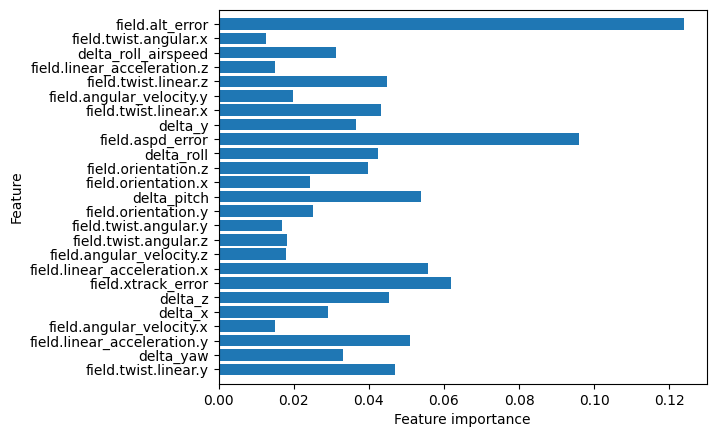

In [ ]:
# WITH ERROR COLUMNS:
#
concatted_ndarray = concatted_dfs.to_numpy()
rf = RandomForestClassifier()
rf.fit(concatted_ndarray, concatted_y)
# Plot the feature importances
plot_feature_importances(rf)

# Select the n best features
n = 20 # Removing 7 (the ones that are clearly not performing
couples = list(zip(concatted_dfs.columns, rf.feature_importances_))
couples.sort(key=lambda x: x[1])
accepted_features = list(map(lambda x: x[0], feature_mask[:n]))
feature_mask = ["flight", "step", *[c[0] for c in couples if (c[0] in accepted_features)] ]

###### Without error columns:

In [ ]:
# WITHOUT ERROR COLUMNS:
#
concatted_dfs = concatted_dfs.drop(["field.alt_error", "field.xtrack_error", "field.aspd_error"], axis=1)
concatted_ndarray = concatted_dfs.to_numpy()
rf = RandomForestClassifier()
rf.fit(concatted_ndarray, concatted_y)
# Plot the feature importances
plot_feature_importances(rf)

# Select the n best features
n = 20 # Removing 7 (the ones that are clearly not performing
couples = list(zip(concatted_dfs.columns, rf.feature_importances_))
couples.sort(key=lambda x: x[1])
accepted_features = list(map(lambda x: x[0], feature_mask[:n]))
feature_mask = ["flight", "step", [c[0] for c in couples if (c[0] in accepted_features )]* ]

### Rebalancing:


In [11]:
import random
import numpy as np
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

class DTW_SMOTE():
  """
  Inputs:
    T = multi-indexed Pandas Dataframe
    N = Amount of SMOTE N %;
    k = Number of nearest neighbors k;
  """

  def __init__(self, T, N, k, start=0):
    # The amount of SMOTE is assumed to be in integral multiples of 100.
    self.N = int(N/100)
    self.nTimeSeries = np.unique(T.index.get_level_values('flight').to_numpy()).tolist()

    self.T = T
    self.start = start
    self.k = k
    self.synthetic = []

  def populate(self, i, neighbours):
    """
    Saves N synthetic windows (follows the SMOTE pseudo-code implementation)
    Inputs:
      i = minority class focused sample
      neighbours = list of the indexes of the k closest neighbours to i
    """
    for _ in range(self.N):
      # Random Neigbour index
      nn = random.randint(1,self.k)

      # Calculate their distance and multiply it to a random number in between ]0,1]
      # then summ the randomly modified distance to the OG array :)
      neighbourIndex = neighbours[nn]
      new_sample = i.sub(self.T[self.T.index.get_level_values('flight') == neighbourIndex])
      #new_sample = i.sub(self.T[self.T.index.get_level_values('flight') == neighbourIndex])

      # We hate indexes around here
      i.drop("flight", inplace=True)
      i.drop("step", inplace=True)
      i = i.to_numpy()

      # multiply each column to a random number in the range ]0,1] ( Einsum best feature ever)
      new_sample = np.add(i, np.einsum('ij,j->ij', new_sample, np.rand(len(features))))

      # And obviusly save it :)
      self.synthethic.append(new_sample)


  def run(self, y):
    """
    Output:
     All the new data for minority class T
    """
    # Number of windows
    lenn = len(self.nTimeSeries)

    # We need this to trick sktime into doing work for us :)
    fake_y = np.zeros(lenn)

    # Fit The KNeighbours table
    knn = KNeighborsTimeSeriesClassifier(n_neighbors=self.k, distance='dtw')
    knn.fit(T, fake_y)

    # Range over all the Instances of the Minority Class
    instances = np.unique(self.T.index.get_level_values('flight').to_numpy()).tolist()
    for i in instances:
      small_df = self.T[self.T.index.get_level_values('flight') == i]
      # Compute the KNeighbours of class i
      dist, ind= knn.kneighbors(small_df, self.k+1, return_distance=True)
      # We can't keep i as a viable neighbour!
      nnarray = [ tup[1] for tup in zip(dist, ind) if tup[0]!=0]
      assert len(nnarray)==self.k, "i can't be a neighbour of himself"
      # Populate with N new values
      self.populate(small_df, nnarray)

    # Return a new multi-indexed DF containing all the data (original + synthetic)
    synthetic = toMultiIndexed(self.synthetic, feature_mask, start= self.start)
    new_X_train = pd.concat([self.T, synthetic ])
    new_X_train = new_X_train.set_index(["flight", "step"])
    # Also return a new numpy array with the new y
    new_y = [ y for _ in range(lenn + len(synthetic))]

    return  new_X_train,  new_y

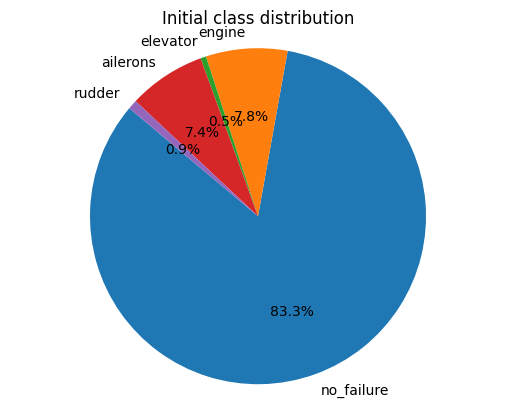

Classes size with respect to TRAIN size:
	 ->no_failure: 83.29%
	 ->engine: 7.84%
	 ->elevator: 0.54%
	 ->ailerons: 7.44%
	 ->rudder: 0.90%


In [12]:
# Ok now run DWT_SMOT on all the minority classes... But how do we define minority ?
# Easy, with counter and percentages :)

# First lets plot a piechart:
from collections import Countepython -m build --wheelr
import matplotlib.pyplot as plt

def plotPie(cDistribution, title):
  sizes, labels = [], []
  for item in cDistribution.items():
    labels.append(item[0])
    sizes.append(item[1])

  plt.pie(sizes,  labels=labels, autopct='%1.1f%%', startangle=140)
  plt.title(title)

  plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.show()

# Obviusly get the distribution of the on the train y (right Alberto?)
cDistrubution = Counter(y_train.tolist())
cDistribution = {classToString[item[0]]:item[1] for item in cDistrubution.items()}
plotPie(cDistribution, "Initial class distribution")

# Get the distributions percentages to decide whether to use DWT_SMOTE or not
lenDataset = y_train.shape[0]
print("Classes size with respect to TRAIN size:")
distribution = {stringToClass[item[0]]: item[1]/lenDataset for item in cDistribution.items()}
# Also print them for fu.an
for item in cDistribution.items():
  print(f"\t ->{item[0]}: {float((item[1]/lenDataset)*100):.2f}%")

In [14]:
import numpy as np

# Run DWT_SMOTE for all the classes that are considered a minority
minorityThreshold = 0.25
max_index = int(np.max(X_train.index.get_level_values('flight').to_numpy()))

new_X_train, new_y_train = [], []
n_classes = len(classToString)

for item in distribution.items():
  indexes = [i for i, c in enumerate(y_train.tolist()) if c ==item[0]]

  if item[1]> minorityThreshold:

    # Multiplier to make the the quantity of the oversampled
    # class equal to the ((1/n_classes)*100)% of the train dataset
    undersamplePercentage = ((1/n_classes)/item[1])
    nSamples = int(item[1]*undersamplePercentage)

    # NB: we should add Tomek-links removal first, like in SMOTEN,
    # before randomly sampling to the desired percentage ...

    # Undersample the huge class :_)
    new_indexes = np.random.choice(a=indexes, size=nSamples, replace=False) # With no repetition !

    # Save the new Dataframe and labels
    new_X_train.append(pd.DataFrame(X_train[X_train.index.get_level_values('flight').isin(new_indexes)]))
    new_y_train += [item[0] for _ in range(nSamples)]

  else:
    # SMOTE PARAMS:
    T =  pd.DataFrame(X_train[X_train.index.get_level_values('flight').isin(indexes)]) # X_train[X_train["flight"] in indexes]
    N=500
    k=5

    # Run DTW_SMOTE
    sampler = DTW_SMOTE(T, N, k, start= max_index)
    fX, fy= sampler.run(item[0])

    # Save the values
    new_X_train.append(fX)
    new_y_train += fy
    max_index += len(fy)


/usr/local/lib/python3.10/dist-packages/sktime/base/_base_panel.py:542: UserWarning: only single label seen in y passed to fit of classifier KNeighborsTimeSeriesClassifier
  warn(


AttributeError: 'KNeighborsTimeSeriesClassifier' object has no attribute '_X'

In [ ]:
# Resave the values as nothing happened ( The new inputs )
X_train = pd.concat(new_X_train)
y_train = np.array(new_y_train)

# Final class distribution
cDistrubution = Counter(y_train.tolist())
cDistribution = {classToString[item[0]]:item[1] for item in cDistrubution.items()}
plotPie(cDistribution, "Class distribution after DTW_SMOTE")

## Testing Models:

In [ ]:
#  Apply feature Masks to the inputs
X_train, X_test = X_train[feature_mask], X_test[feature_mask]

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

,name,object
0,Arsenal,<class 'sktime.classification.kernel_based._ar...
1,BOSSEnsemble,<class 'sktime.classification.dictionary_based...
2,BOSSVSClassifierPyts,<class 'sktime.classification.dictionary_based...
3,BaggingClassifier,<class 'sktime.classification.ensemble._baggin...
4,CNNClassifier,<class 'sktime.classification.deep_learning.cn...
5,CNTCClassifier,<class 'sktime.classification.deep_learning.cn...
6,CanonicalIntervalForest,<class 'sktime.classification.interval_based._...
7,Catch22Classifier,<class 'sktime.classification.feature_based._c...
8,ClassifierPipeline,<class 'sktime.classification.compose._pipelin...
9,ColumnEnsembleClassifier,<class 'sktime.classification.compose._column_...


CONVOLUTIONAL NEURAL NETWORK
667/667 [==============================] - 1s 2ms/step
Accuracy: 0.85

Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      1.00      0.92      2243
         1.0       0.00      0.00      0.00         7
         2.0       0.80      0.10      0.18       195
         3.0       0.00      0.00      0.00        24
         4.0       0.17      0.01      0.01       199

    accuracy                           0.85      2668
   macro avg       0.36      0.22      0.22      2668
weighted avg       0.78      0.85      0.79      2668



TypeError: unsupported format string passed to builtin_function_or_method.__format__

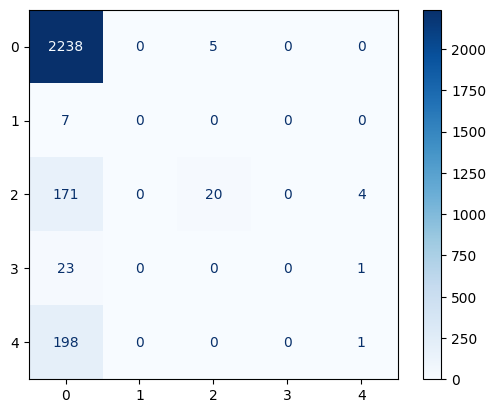

In [ ]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.feature_based import RandomIntervalClassifier
from sktime.classification.deep_learning.cnn import CNNClassifier
from sktime.datatypes import check_raise
from sklearn.model_selection import LearningCurveDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline
from sktime.transformations.panel.padder import PaddingTransformer
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.transformations.panel.interpolate import TSInterpolator

print("CONVOLUTIONAL NEURAL NETWORK")
cnn = CNNClassifier(n_epochs=50, batch_size=4, kernel_size=7, avg_pool_size=1, n_conv_layers=3, loss='binary_crossentropy')
check_raise(X_train, mtype="pd-multiindex")
check_raise(y_train, mtype='np.ndarray')
cnn.fit(X_train, y_train)

y_pred_cnn = cnn.predict(X_test)

cnn_acc = accuracy_score(y_test, y_pred_cnn)
print(f"Accuracy: {cnn_acc:.2f}")

report = classification_report(y_test, y_pred_cnn, zero_division = 0.0)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_test, y_pred_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classToString.items)#display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

#clf = Pipeline([
#    ("transform", TSInterpolator(50)),
#     ("concatenate", ColumnConcatenator()),
#     ("classify", TimeSeriesForestClassifier(n_estimators=100)),
#    ("transform", PaddingTransformer()),
#    ("classify", RandomIntervalClassifier(n_intervals=10)),
#])
#clf.fit(X_train, y_train)
#clf.score(X_test,y_test)

RECURRENT NEURAL NETWORK
134/134 [==============================] - 0s 2ms/step
Accuracy: 0.88

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.99      0.94      2243
         1.0       0.00      0.00      0.00         7
         2.0       0.82      0.67      0.74       195
         3.0       0.81      0.54      0.65        24
         4.0       0.25      0.01      0.01       199

    accuracy                           0.88      2668
   macro avg       0.56      0.44      0.47      2668
weighted avg       0.83      0.88      0.85      2668



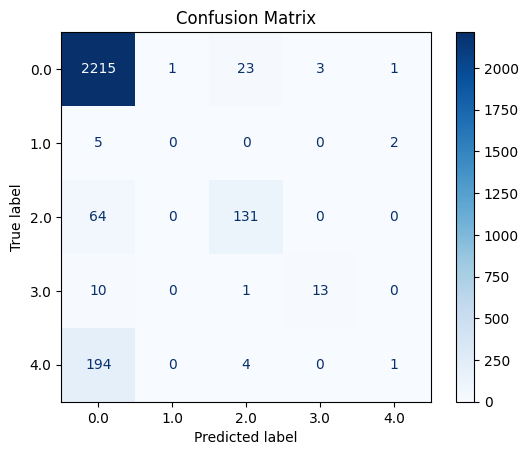

In [ ]:
from sktime.classification.deep_learning.rnn import SimpleRNNClassifier

print("RECURRENT NEURAL NETWORK")
rnn = SimpleRNNClassifier(n_epochs=50, batch_size=20, loss='binary_crossentropy')
rnn.fit(X_train, y_train)
# rnn.score(X_test, y_test)

y_pred_rnn = rnn.predict(X_test)

rnn_acc = accuracy_score(y_test, y_pred_rnn)
print(f"Accuracy: {rnn_acc:.2f}")

report = classification_report(y_test, y_pred_rnn, zero_division = 0.0)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_test, y_pred_rnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


K-NEIGHBORS


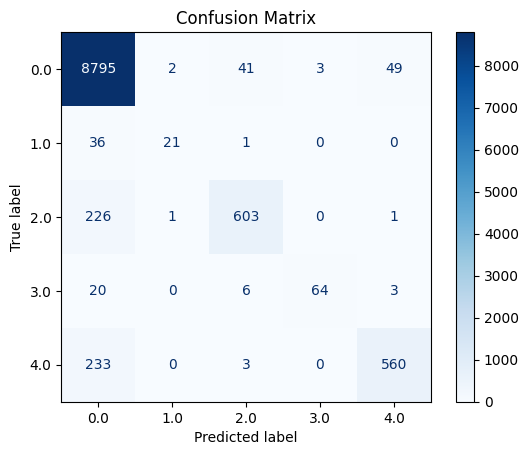

In [ ]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

print("K-NEIGHBORS")
knn = KNeighborsTimeSeriesClassifier(n_neighbors=5, distance='dtw')
knn.fit(X_train, y_train)

y_pred_knn_train = knn.predict(X_train)

cm = confusion_matrix(y_train, y_pred_knn_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

K-NEIGHBORS
Accuracy della KNN: 0.90

Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.98      0.94      2243
         1.0       0.00      0.00      0.00         7
         2.0       0.82      0.55      0.66       195
         3.0       0.90      0.79      0.84        24
         4.0       0.73      0.44      0.55       199

    accuracy                           0.90      2668
   macro avg       0.67      0.55      0.60      2668
weighted avg       0.89      0.90      0.89      2668



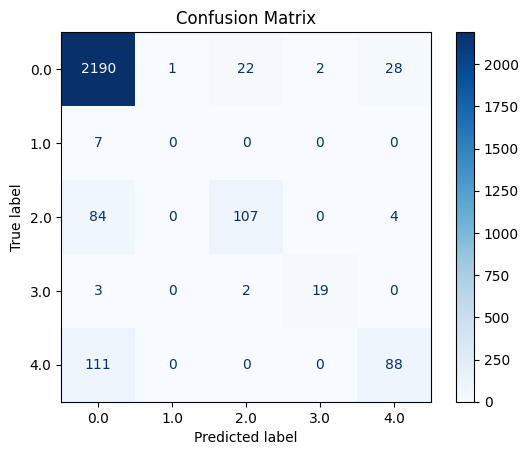

In [ ]:
y_pred_knn = knn.predict(X_test)

knn_acc = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy della KNN: {knn_acc:.2f}")

report = classification_report(y_test, y_pred_knn, zero_division = 0.0)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()